# Machine Learning for Wind Farm Perdiction Using Two Phase Clustering
# Phase1 = Distance, Phase 2 = Capacity + Distance

In [57]:
%matplotlib inline
import sys
import os
import re
import csv
import numpy as np
import scipy as sp
import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
import sklearn.metrics as metrics
import matplotlib
import matplotlib.pyplot as plt

## Setting up the design matrix

In [58]:
def preprocess(path = "./wind_capacity_factors_months_2_5_8.csv"):
    """
    A helper method
    pre-procss the data
    returns a dictionary of wind_point_id -> features
    the first two features is lat and lon, and the rest is all the capacity factors
    """
    
    # attributes = ['hour', 'wind_point_id', 'avg(capacity_factor)', 'lon', 'month', 'year', 'lat', 'day']
    # Load the wind CSV file
    windFile = path
    input_train_file = csv.DictReader(open(windFile))
    
    wind_point_dictionary = {}

    # keep the latitude and longitude of each point for plotting purposes
    position = []

    for row in input_train_file:
        wind_point_id = row['wind_point_id']
        features = []
        # we've added this point previously, so we just append the feature:
        if wind_point_id in wind_point_dictionary:
            features = wind_point_dictionary[wind_point_id]
            features.append(float(row['avg(capacity_factor)']))
            pass
        # we've not seen this point before:
        else:
            features.append(float(row['lat']))
            features.append(float(row['lon']))
            position.append([float(row['lat']), float(row['lon'])])
            features.append(float(row['avg(capacity_factor)']))
        # update the dictionary
        wind_point_dictionary[wind_point_id] = features

    position = np.array(position)
    
    return (position, wind_point_dictionary)

def preprocess2(folder_name = "Easter_Cape_Cod_MA") :
    '''
    Folder contains many csv files. Each csv file contains capacity factors of a wind point.
    preprocess2 returns a list of position of each wind point and wind point dictionary whose key is a site id 
    and value is a list consisting of the position(lat, lon) and the averages of capacity factors of each hour. 
    '''
    wind_point_dictionary = {}
    positions = []
    match = r".+\.csv"
    for root, subdirs, files in os.walk("./" + folder_name):
        for filename in files:
            # To check if the file is in the format of csv or not
            if (re.match(match, filename) != None) :
                features = []
                file_path = os.path.join(root, filename)
                # Open each file, create a list of features of a wind_point and add it to wind_point_dictionary(dictionary)
                # Also, create a list named position and append it to positions(list)
                with open(file_path, 'r') as f:
                    f_contents = f.readlines()
                    position = []
                    for counter, line in enumerate(f_contents) :
                        if (counter == 0) :
                            # store wind point id to a variable (later, it will be a key for dictionary)
                            wind_point_id = float(line.strip().split(",")[-1])
                        elif (counter == 1) :
                            # store longitude to a variable (to append lat and lon in order)
                            lon = float(line.strip().split(",")[-1])
                        elif (counter == 2) :
                            # append lat to features
                            lat = float(line.strip().split(",")[-1])
                            features.append(lat)
                            position.append(lat)
                        elif (counter == 3) :
                            # append lon to features and position. skip 4th row since it's just the names of columns 
                            features.append(lon)
                            position.append(lon)
                            pass
                        elif ((counter - 4) % 12 == 0) :
                            # append the first "minute" of an hour 
                            features.append(float(line.strip().split(",")[-1]))
                        elif ((counter - 4) % 12 == 11) :
                            # add the last "minute" of an hour and divide it by 12 to find the average
                            features[-1] += float(line.strip().split(",")[-1])
                            features[-1] /= 12
                        else :
                            # add 2nd to 11th "minutes" of an hour
                            features[-1] += float(line.strip().split(",")[-1])
                    positions.append(position)
                    wind_point_dictionary[wind_point_id] = features
                    f.close()
    positions = np.array(positions)
    return (positions, wind_point_dictionary)

def load_design_matrix():
    """
    call this method to load the entire data matrix
    """
    position, wind_point_dictionary = preprocess()
    # next step: build the design matrix
    matrix = None
    

    for key in wind_point_dictionary.keys() :
        features = np.copy(wind_point_dictionary[key]) 
        #features = featureEngineering(features)
    
        if matrix is None:
            matrix = np.array([features])
        else:
            matrix = np.append(matrix, [features], axis = 0)
    
    return (position, matrix)


def load_geo_matrix():
    """
    call this method to load the geographic matrix (only contains longitude and latitude)
    """
    position, wind_point_dictionary = preprocess()
    # next step: build the design matrix
    matrix = None
    

    for key in wind_point_dictionary.keys() :
        features = np.copy(wind_point_dictionary[key][:2]) 
        #features = featureEngineering(features)
    
        if matrix is None:
            matrix = np.array([features])
        else:
            matrix = np.append(matrix, [features], axis = 0)
    
    return (position, matrix)


def load_capacity_matrix():
    """
    call this method to load the capacity factors matrix.
    """
    position, wind_point_dictionary = preprocess()
    # next step: build the design matrix
    matrix = None
    

    for key in wind_point_dictionary.keys() :
        features = np.copy(wind_point_dictionary[key][2:]) 
        #features = featureEngineering(features)
    
        if matrix is None:
            matrix = np.array([features])
        else:
            matrix = np.append(matrix, [features], axis = 0)
    
    return (position, matrix)



## Clustering Algorithms 

### Hyper-paremeters

There are three ways to determine the number of clusters

1. Use a simple heruistic where $k= \sqrt{n/2}$ where n is the number of wind_points
2. Use the elbow method https://bl.ocks.org/rpgove/0060ff3b656618e9136b
3. Use the gap statistic method http://www.stanford.edu/~hastie/Papers/gap.pdf stats departmen

Option 1 is the quickest way, as it only requires $O(1)$ time. 
Option 2 is more time comsuming because it involves running clustering algorithm multiple times.
Option 3 is the most sophisicated, but it requires a lot of computation within each cluster so it might not scale well when we bring the entire U.S wind points into consideration

#### Gap Statistic
1. Suppose that we have clustered the data into k clusters $C_1, C_2,...,C_k$ and $n_r = \left|C_r\right|$
2. We defeine the pairwise distance between all two points i, j in a cluster to be: $D_r = \sum_{i,j\in C_r}{d(i,j)} $
3. We define the sum of pairwise distance for all clusters to be: $W_k=\sum_{r=1}^{k}{\dfrac{1}{2n_r}D_r}$
4. $Gap_n(k) = E^*_n\{logW_k\} - logW_k$

Algorithm (https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/):
1. Cluster the observed data, varying the number of clusters from $k = 1, ..., k_{\mathrm{max}}$, and compute the corresponding W_k.
2. Generate B reference data sets and cluster each of them with varying number of clusters $k = 1, ..., k_{\mathrm{max}}$. Compute the estimated gap statistic $\mathrm{Gap}(k) = (1/B) \sum_{b=1}^B \log W^*_{kb} - \log W_k$.
3. With $\bar{w} = (1/B) \sum_b \log W^*_{kb}$, compute the standard deviation $\mathrm{sd}(k) = [(1/B) \sum_b (\log W^*_{kb} - \bar{w})^2]^{1/2}$ and define $\displaystyle s_k = \sqrt{1+1/B}\,\mathrm{sd}(k)$.
4. Choose the number of clusters as the smallest k such that $\mathrm{Gap}(k) \geq \mathrm{Gap}(k+1) - s_{k+1}$.

In [59]:
def gap_statistic(matrix, min_n_clusters = 1, max_n_clusters = 100, step = 5, B = 5, switch="all"):
    # First generate W_k for the original data
    # print "Generating W_k for original matrix"
    Wk_map = calculate_W_k(matrix, min_n_clusters = min_n_clusters, max_n_clusters = max_n_clusters, step = step)
    
    n_clusters = []
    log_Wk_origins = []
    log_Wk_refs = []
    gaps = []
    s_k_array = []
    # Second generate W_k for the B different reference(random) matrices
    # iterate through each n_clusters
    for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
        #if n_cluster % 10 <= 1:
        #    print "Calculating Gap Statistic for n_cluster = " + str(n_cluster) 
        # logWk for original data points
        log_Wk = np.log(Wk_map[n_cluster])
        log_Wk_origins.append(log_Wk)
        
        log_Wk_ref = 0
        log_Wkb_array = [] # store intermediate result for each b
        # create b sample points
        for b in range(B):
            matrix_ref = random_matrix(matrix, switch)
            # calculate Wkb for each sample b
            Wkb_map_ref = calculate_W_k(matrix_ref, min_n_clusters = n_cluster, max_n_clusters = n_cluster, step = 1)
            log_Wkb = np.log(Wkb_map_ref[n_cluster])
            log_Wk_ref += log_Wkb
            # store Wkb
            log_Wkb_array.append(log_Wkb)
        
        # calculate log_Wk_ref
        log_Wk_ref = float(log_Wk_ref) / float(B)
        log_Wk_refs.append(log_Wk_ref)
        
        # calculate gap
        gaps.append(log_Wk_ref - log_Wk)
        
        # calculate sd(k), based on log_Wk_ref
        sd_k = 0
        for b in range(B):
            log_Wkb = log_Wkb_array[b]
            sd_k += np.square(log_Wkb - log_Wk_ref)
        sd_k = np.sqrt(float(sd_k) / float(B))
        
        # calculate sk
        s_k = np.sqrt(1 + 1.0/B) * sd_k
        s_k_array.append(s_k)
            
        n_clusters.append(n_cluster)
    return (n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array)
    

def random_matrix(matrix, switch, lat = (31, 34), lon = (-120, -100)):
    """
    switch = geo: generate a random matrix only for latitute and longitute
    switch = all: generate a random matrix for all features
    
    generate a random wind data matrix.
    Each wind data has 2186 features. The first two features are the inflated 
    latitude and longitude
    latitude is in the range of [31, 34]
    longitude is in the range of [-120, -100]
    The rest of the 2184 features are capacities.
    Each of them is in the range [0,1]
    """
    random_matrix = None
    
    if switch == "geo" or switch == "all":
        random_matrix = np.random.rand(matrix.shape[0],matrix.shape[1])
        # need to inflate the position numbers
        for i in range(random_matrix.shape[0]):
        # To sample Unif[a, b), b > a
        # use (b - a) * random_sample() + a
            random_matrix[i][0] = (lat[1] - lat[0]) * np.random.random_sample() + lat[0]
            random_matrix[i][1] = (lon[1] - lon[0]) * np.random.random_sample() + lon[0]
    if switch == "capacity":
        random_matrix = np.random.rand(matrix.shape[0],matrix.shape[1] + 2)
        for i in range(random_matrix.shape[0]):
        # To sample Unif[a, b), b > a
        # use (b - a) * random_sample() + a
            random_matrix[i][0] = (lat[1] - lat[0]) * np.random.random_sample() + lat[0]
            random_matrix[i][1] = (lon[1] - lon[0]) * np.random.random_sample() + lon[0]
            
    return random_matrix




def calculate_W_k(matrix, min_n_clusters, max_n_clusters, step):
    """
    calculate the W_k of the provided data by first clustering them and then 
    compute the pairwise distance between all two points within each cluster
    """
    W_k_map = {}
    for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
        # using the given clustering method to cluster the data
        kmeans = KMeans(n_clusters=n_cluster, random_state=0)
        labels = kmeans.fit_predict(matrix)
        
        # agglomerative = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', affinity='euclidean')
        # labels = agglomerative.fit_predict(matrix)
        
        clusters = {}
        # First Pass
        # group wind points to their perspective clusters
        for i in range(len(labels)):
            cluster_num = labels[i]
            wind_point = np.copy(matrix[i])
            
            if cluster_num not in clusters:
                members = []
                members.append(wind_point)
                clusters[cluster_num] = members
            else:
                members = clusters[cluster_num]
                members.append(wind_point)
                clusters[cluster_num] = members
                
        W_k = 0
        # Second Pass, calculate the sum of the pair wise distance in each cluster
        for cluster in clusters:
            points = clusters[cluster]
            size = len(points) # the number of wind points in this cluster
            W_k += float(pair_wise(points)) / float(2 * size)
        
        W_k_map[n_cluster] = W_k
    
    return W_k_map
            

def pair_wise(points):
    """
    Calculate the pair_wise distance between all points in a cluster.
    Here we use 2 norm (Euclidean distance)
    """
    return np.sum(sp.spatial.distance.pdist(np.array(points), metric='euclidean'))

        
    
 

## Utils

In [79]:
def plotGapComparsion(n_clusters, log_Wk_refs, log_Wk_origins):
    plt.plot(n_clusters, log_Wk_refs, c="black", alpha=0.7)
    plt.plot(n_clusters, log_Wk_refs, 'ro', label = "$(1/B) \sum_b \log W^*_{kb}$", alpha=0.7) #'ro' means red o

    plt.plot(n_clusters, log_Wk_origins, c="black", alpha=0.7)
    plt.plot(n_clusters, log_Wk_origins, 'bo', label = "$logW_k$", alpha=0.7) #'bo' means blue o
                    
    plt.title("Gap Statistic for Capacity")
    plt.xlabel("n_clusters")
    plt.grid(True)
    plt.legend(loc='center right')
    plt.show()


    # plot the gap statistic
def plotGapStatistic(n_clusters, gaps, s_k_array):
    result = []
    count = 1
    for k in range(len(gaps)):
        if k != len(gaps) - 1:
            result.append(gaps[k] - gaps[k+1] + s_k_array[k+1])
            if (gaps[k] - gaps[k+1] + s_k_array[k+1]) > 0:
                print "Qualifying k! count: " + str(count) + ", n_cluster: " + str(n_clusters[k])
                count += 1

    plt.figure(figsize=(15,15))
    plt.bar(n_clusters[1:], result, align='center', alpha=0.5, label = '$\mathrm{Gap}(k) - \mathrm{Gap}(k+1) + s_{k+1}$')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.xlabel("n_clusters")
    plt.show()

    
def plotReferenceData(matrix, position, switch, lat = (31, 34), lon = (-120, -100)):
    # A comparasion of reference data and true data
    matrix_ref = random_matrix(matrix, switch, lat, lon)
    position_ref = []
    for i in range(matrix_ref.shape[0]):
        position_ref.append([matrix_ref[i][0], matrix_ref[i][1]])                          
    position_ref = np.array(position_ref)


    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position_ref[:,0], position_ref[:,1], c='red', s=75, alpha = 0.6, label = "reference wind point")
    plt.scatter(position[:,0], position[:,1], c='blue', s=75, alpha = 0.6, label = "true wind point")

    plt.grid(True)
    plt.legend(loc='upper right')
    plt.xlabel("latitude")
    plt.ylabel("longitude")

    plt.show()
    

def plotClassification(position, labels):
    """
    Given position of the points and the labels, plot classification
    """
    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position[:,0], position[:,1], c=labels, cmap=plt.cm.spectral, s=50) 
    plt.show()


def plotKmeansClassification(position, labels, kmenas):
    """
    Given position of the points and the labels produced by kmeans, plot classification
    """
    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position[:,0], position[:,1], c=labels, cmap=plt.cm.spectral, s=50)
    
    centroids = kmeans.cluster_centers_

    # We inflate the position features during feature engineering, so we need to restore them back. 
    centroids_position = np.array([[centroids[i][0], centroids[i][1]] for i in range(centroids.shape[0])])

    plt.scatter(centroids_position[:, 0], centroids_position[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
    plt.show()
    
def pass1Analysis(position, matrix, min_n_clusters = 1, max_n_clusters = 100, step = 1, B = 5, switch="geo"):
    """
    A graphic analysis for pass1
    """
    # Calculate parameters
    n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array = gap_statistic(matrix, min_n_clusters = min_n_clusters, max_n_clusters = max_n_clusters, step = step, B = B, switch=switch)
    # Plot
    plotGapComparsion(n_clusters, log_Wk_refs, log_Wk_origins)
    plotGapStatistic(n_clusters, gaps, s_k_array)
    plotReferenceData(matrix, position, switch = switch)

    
def pass1(matrix, n_cluster = 33):
    """
    Classify the data points based on the given matrix
    """
    agglomerative = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', affinity='euclidean')
    labels = agglomerative.fit_predict(matrix)
    
    clusters = {}
    for i in range(matrix.shape[0]):
        label = labels[i]
        if label in clusters:
            points = clusters[label]
            # Wind points start at 1
            points.append(i + 1)
            clusters[label] = points
        else:
            points = []
            # Wind points start at 1
            points.append(i + 1)
            clusters[label] = points
    
    return clusters

def pass1_automation(matrix, switch = "geo"):
    """
    Classify the data points based on the given matrix
    """
    # Calculate parameters
    n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array = gap_statistic(matrix, min_n_clusters = 1, max_n_clusters = max(int(np.sqrt(matrix.shape[0])), min(80, matrix.shape[0])), step = 1, B = 5, switch=switch) 
    # Determine k, the optimal number of clusters
    optimal_num_cluster = int(np.sqrt(matrix.shape[0])) + 1 # default value if there is no optimal cluster
    found = False # set this to true if we've find the optimal number of the cluster
    for k in range(len(gaps)):
        if not found:
            if k != len(gaps) - 1:
                if (gaps[k] - gaps[k+1] + s_k_array[k+1]) > 0:
                    optimal_num_cluster = n_clusters[k]
                    found = True
                    
    kmeans = KMeans(n_clusters=optimal_num_cluster, random_state=0)
    labels = kmeans.fit_predict(matrix)
    
    clusters = {}
    for i in range(matrix.shape[0]):
        label = labels[i]
        if label in clusters:
            points = clusters[label]
            # Wind points start at 1
            points.append(i + 1)
            clusters[label] = points
        else:
            points = []
            # Wind points start at 1
            points.append(i + 1)
            clusters[label] = points
    
    return clusters


def load_geo_matrix_on_cluster(wind_points, design_matrix):
    """
    Generate the geo matrix for all points in a specific cluster.
    The sequence of the rows of the matrix follows the same order as the wind_points 
    """
    position = []
    matrix = None
    

    for i in range(design_matrix.shape[0]):
        if i + 1 in wind_points:
            features = np.copy(design_matrix[i][:2]) 
            position.append(np.copy(design_matrix[i][:2]))
    
            if matrix is None:
                matrix = np.array([features])
            else:
                matrix = np.append(matrix, [features], axis = 0)
                
    position = np.array(position)
    
    return (position, matrix)


def load_capacity_matrix_on_cluster(wind_points, design_matrix):
    """
    Generate the capacity matrix for all points in a specific cluster.
    The sequence of the rows of the matrix follows the same order as the wind_points 
    """
    position = []
    matrix = None
    
    for i in range(design_matrix.shape[0]):
        if i + 1 in wind_points:
            features = np.copy(design_matrix[i][2:]) 
            position.append(np.copy(design_matrix[i][:2]))
    
            if matrix is None:
                matrix = np.array([features])
            else:
                matrix = np.append(matrix, [features], axis = 0)
                
    position = np.array(position)
    
    return (position, matrix)

def load_matrix_on_cluster(wind_points, design_matrix):
    """
    Generate the capacity matrix for all points in a specific cluster.
    The sequence of the rows of the matrix follows the same order as the wind_points 
    """
    position = []
    matrix = None
    

    for i in range(design_matrix.shape[0]):
        if i + 1 in wind_points:
            features = np.copy(design_matrix[i]) 
            position.append(np.copy(design_matrix[i][:2]))
    
            if matrix is None:
                matrix = np.array([features])
            else:
                matrix = np.append(matrix, [features], axis = 0)
                
    position = np.array(position)
    
    return (position, matrix)
    
    

def pass2Analysis(clusters, design_matrix, cluster_num=5, lat = (31, 34), lon = (-120, -100), switch = "all"):
    """
    A graphic analysis for pass2
    capacity_clusters: input based on pass 1
    cluster_num: which specific capacity cluster do you want to classify based on the 
    """
    # Get a specific cluster
    sample_cluster = clusters[cluster_num]
    # Generate the matrix for this cluster
    position, matrix = None, None
    if switch == "capacity":
        position, matrix = load_capacity_matrix_on_cluster(sample_cluster, design_matrix)
    if switch == "geo":
        position, matrix = load_geo_matrix_on_cluster(sample_cluster, design_matrix)
    if switch == "all":
        position, matrix = load_matrix_on_cluster(sample_cluster, design_matrix)
    # Calculate parameters
    n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array = gap_statistic(matrix, min_n_clusters = 1, max_n_clusters = max(int(np.sqrt(matrix.shape[0])), 40), step = 1, B = 5, switch=switch)
    # Plot
    plotGapComparsion(n_clusters, log_Wk_refs, log_Wk_origins)
    plotGapStatistic(n_clusters, gaps, s_k_array)
    plotReferenceData(matrix, position, switch = switch, lat = lat, lon = lon)


def pass2(clusters, design_matrix, lat = (31, 34), lon = (-120, -100), switch = "all"):
    """
    Based on the clusters from pass1, we classify the data based on geographic features.
    Return the final clustering assignment
    The format of the final labels
    """
    
    final_labels = {}
    
    for label1 in clusters:
        # Get all the wind points belonging to this cluster
        wind_points = clusters[label1]
        # Generate the matrix for this cluster
        position, matrix = None, None
        if switch == "capacity":
            position, matrix = load_capacity_matrix_on_cluster(wind_points, design_matrix)
        if switch == "geo":
            position, matrix = load_geo_matrix_on_cluster(wind_points, design_matrix)
        if switch == "all":
            position, matrix = load_matrix_on_cluster(wind_points, design_matrix)
        # Calculate parameters
        n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array = gap_statistic(matrix, min_n_clusters = 1, max_n_clusters = max(int(np.sqrt(matrix.shape[0])), min(40, matrix.shape[0])), step = 1, B = 5, switch=switch) 
        # Determine k, the optimal number of clusters
        optimal_num_cluster = int(np.sqrt(len(wind_points))) + 1 # default value if there is no optimal cluster
        found = False # set this to true if we've find the optimal number of the cluster
        for k in range(len(gaps)):
            if not found:
                if k != len(gaps) - 1:
                    if (gaps[k] - gaps[k+1] + s_k_array[k+1]) > 0:
                        optimal_num_cluster = n_clusters[k]
                        found = True
        # classify the data based on the optimal number of clusters
        kmeans = KMeans(n_clusters=optimal_num_cluster, random_state=0)
        labels = kmeans.fit_predict(matrix) 
        # Finally, we combine the label from pass1 and the label from pass2
        i = 0
        for i in range(len(wind_points)):
            label2 = labels[i]
            # get the culster center associated with this wind point for later on performance calculation
            culster_center = kmeans.cluster_centers_[label2]
            # final_labels[wind_points[i]] = str(label1) + ":" + str(label2) + "," + np.array_str(culster_center).replace("\n", "0")
            final_labels[wind_points[i]] = [str(label1) + ":" + str(label2), culster_center]
    
    return final_labels
        
        
                    
def calculate_cluster_rmse(predictions, matrix):
    """
    The prediction format is:
    id, cluster, centroid
    0, 12, [1.1, 2.1, 1.0, 1.9]
    1, 12, [1.1, 2.1, 1.0, 1.9]
    2, 14, [4.1, 4.1, 1.0, 4.9]
    3, 15, [1.2, 2.4, 10.0, 4.9]
    
    matrix: the original data matrix
    """
    clusters_windpoint = {}
    clusters_centroid = {}
    # First Pass
    # group wind points to their perspective clusters
    for i in range(len(predictions)):
        windpoint_num = i + 1
        cluster_num = predictions[windpoint_num][0]
        centroid = predictions[windpoint_num][1]
    

        if cluster_num not in clusters_windpoint:
            members = []
            members.append(windpoint_num)
            clusters_windpoint[cluster_num] = members
            # only need to store centroid once
            clusters_centroid[cluster_num] = centroid
        else:
            members = clusters_windpoint[cluster_num]
            members.append(windpoint_num)
            clusters_centroid[cluster_num] = centroid
            


    clusters_rmse = 0
    # Second Pass, calculate the rmse based on centroids
    for cluster_num in clusters_windpoint:
        cluster = np.array(clusters_windpoint[cluster_num])
        centroid = clusters_centroid[cluster_num]
        centroid.shape = (centroid.shape[0], 1)
        
        
        for windpoint_num in cluster:
            windpoint = matrix[windpoint_num - 1]
            # make it a column vector instead of a row vector
            windpoint.shape = (windpoint.shape[0], 1)
            rmse = np.linalg.norm(windpoint - centroid)
            clusters_rmse += rmse
    
    
    return clusters_rmse


def calculate_cluster_rmse2(predictions, matrix):
    """
    The prediction format is:
    id, cluster, centroid
    0, 12, [1.1, 2.1, 1.0, 1.9]
    1, 12, [1.1, 2.1, 1.0, 1.9]
    2, 14, [4.1, 4.1, 1.0, 4.9]
    3, 15, [1.2, 2.4, 10.0, 4.9]
    
    matrix: the original data matrix
    """
    clusters_windpoint = {}
    # First Pass
    # group wind points to their perspective clusters
    for i in range(len(predictions)):
        windpoint_num = i + 1
        wind_point = np.copy(matrix[i])
        cluster_num = predictions[windpoint_num][0]
    

        if cluster_num not in clusters_windpoint:
            members = []
            members.append(wind_point)
            clusters_windpoint[cluster_num] = members
        else:
            members = clusters_windpoint[cluster_num]
            members.append(wind_point)

    print ("num of clusters: ",  len(clusters_windpoint))
    rmse = 0
    # Second Pass, calculate the rmse based on centroids
    for cluster_num in clusters_windpoint:
        cluster = np.array(clusters_windpoint[cluster_num])
        
        centroid = np.mean(cluster, axis=0)
        
        centroid.shape = (centroid.shape[0], 1)
        
        cluster_rmse = 0
        for windpoint in cluster:
            # make it a column vector instead of a row vector
            windpoint.shape = (windpoint.shape[0], 1)
            pairwise_distance = np.linalg.norm(windpoint - centroid)
            cluster_rmse += pairwise_distance
        
        rmse += cluster_rmse
    
    
    return rmse
        
    

## Feature Selection

In [80]:
def generate_features(num_features):
    """
    num_features: integer, how many features do we want for a single wind point?
    """
    position, wind_point_dictionary = preprocess()
    # next step: build the design matrix
    num_points = len(wind_point_dictionary)
    # We separate each feature as far as possible
    step = int(float(len(wind_point_dictionary['1'])) / num_features)

    matrix = None
    geo_matrix = None
    capacity_matrix = None
    
    for i in range(num_points):
        key = str(i + 1) # the key to access wind_point in the dictionary
        geo_features = np.copy(wind_point_dictionary[key][:2])
        capacity_features = np.copy([wind_point_dictionary[key][j] for j in range(2, len(wind_point_dictionary[key])) if j % step == 0])
        features = np.append(np.copy(geo_features), np.copy(capacity_features))
                                
        if matrix is None:
            matrix = np.array([features])
            geo_matrix = np.array([geo_features])
            capacity_matrix = np.array([capacity_features])
        else:
            matrix = np.append(matrix, [features], axis = 0)
            geo_matrix = np.append(geo_matrix, [geo_features], axis = 0)
            capacity_matrix = np.append(capacity_matrix, [capacity_features], axis = 0)
    
    return (position, matrix, geo_matrix, capacity_matrix)
 


def featureSelection(min_feature_num, max_feature_num, original_design_matrix):
    """
    A full run of the feature selection algorithm
    by selecting features ranging from 0 to max_feature_num
    For each set of features, run the entire two stage clustering algorithm
    """
    for i in range(min_feature_num, max_feature_num):
        position, design_matrix, geo_matrix, capacity_matrix = generate_features(i + 1)
        
        geo_clusters = pass1_automation(geo_matrix)
        print len(geo_clusters)
        final_labels = pass2(geo_clusters, design_matrix)
        
        #print final_labels
        
        print(calculate_cluster_rmse2(final_labels, original_design_matrix))

In [88]:
featureSelection(850, 870, load_design_matrix()[1])

### Pass1, we classify the data based on geographic locations

In [62]:
geo_position, geo_matrix = load_geo_matrix()
position, design_matrix = load_design_matrix()

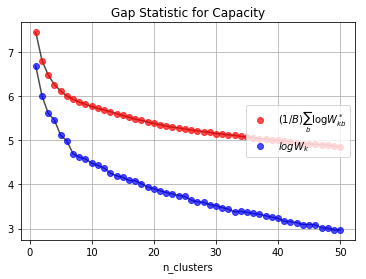

Qualifying k! count: 1, n_cluster: 3
Qualifying k! count: 2, n_cluster: 8
Qualifying k! count: 3, n_cluster: 10
Qualifying k! count: 4, n_cluster: 14
Qualifying k! count: 5, n_cluster: 16
Qualifying k! count: 6, n_cluster: 19
Qualifying k! count: 7, n_cluster: 22
Qualifying k! count: 8, n_cluster: 24
Qualifying k! count: 9, n_cluster: 27
Qualifying k! count: 10, n_cluster: 29
Qualifying k! count: 11, n_cluster: 31
Qualifying k! count: 12, n_cluster: 33
Qualifying k! count: 13, n_cluster: 36
Qualifying k! count: 14, n_cluster: 41
Qualifying k! count: 15, n_cluster: 42
Qualifying k! count: 16, n_cluster: 44
Qualifying k! count: 17, n_cluster: 45
Qualifying k! count: 18, n_cluster: 47
Qualifying k! count: 19, n_cluster: 49


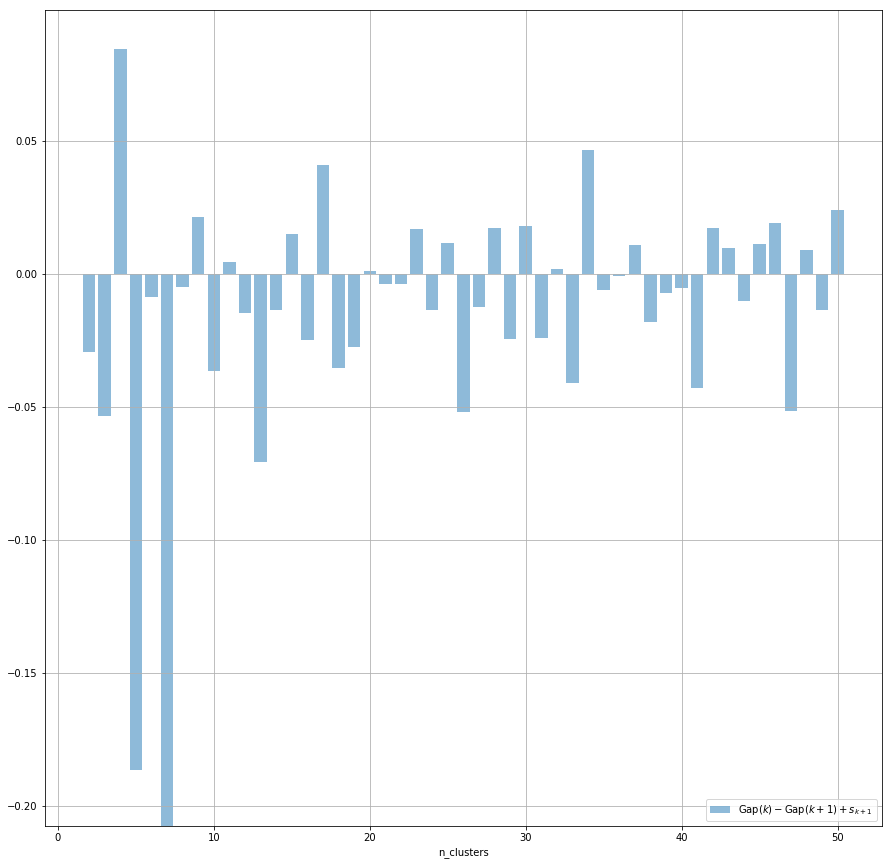

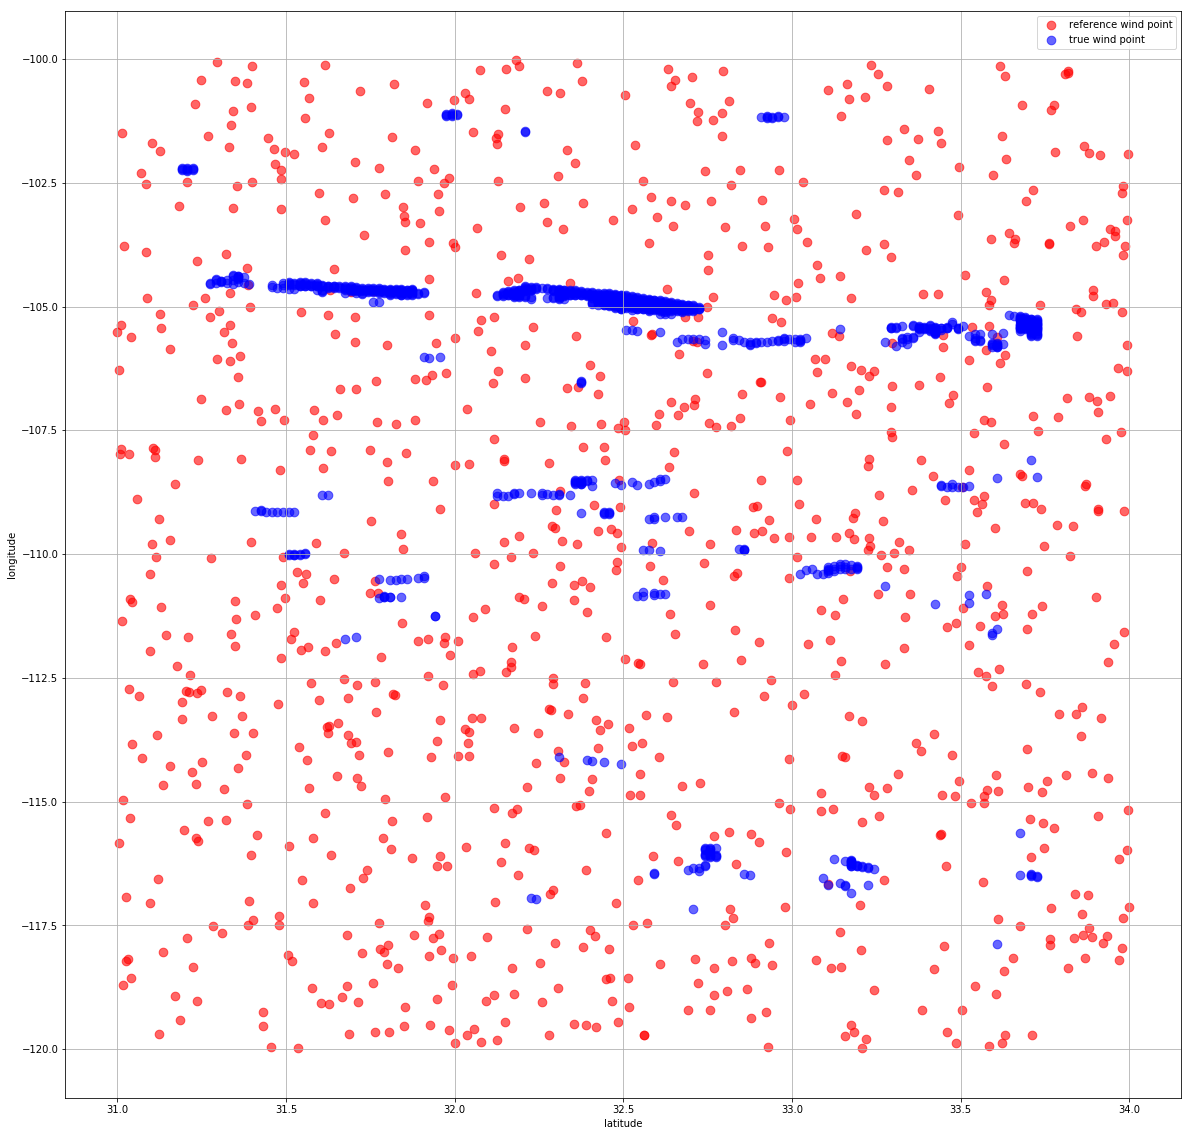

In [63]:
pass1Analysis(geo_position, geo_matrix, min_n_clusters = 1, max_n_clusters = 50, step = 1, B = 5, switch="all")

#### We use num_cluster = 3

In [64]:
kmeans = KMeans(n_clusters=3, random_state=0)
geo_labels = kmeans.fit_predict(geo_matrix)

In [65]:
str(kmeans.cluster_centers_[0])

'[  32.49812674 -104.85256726]'

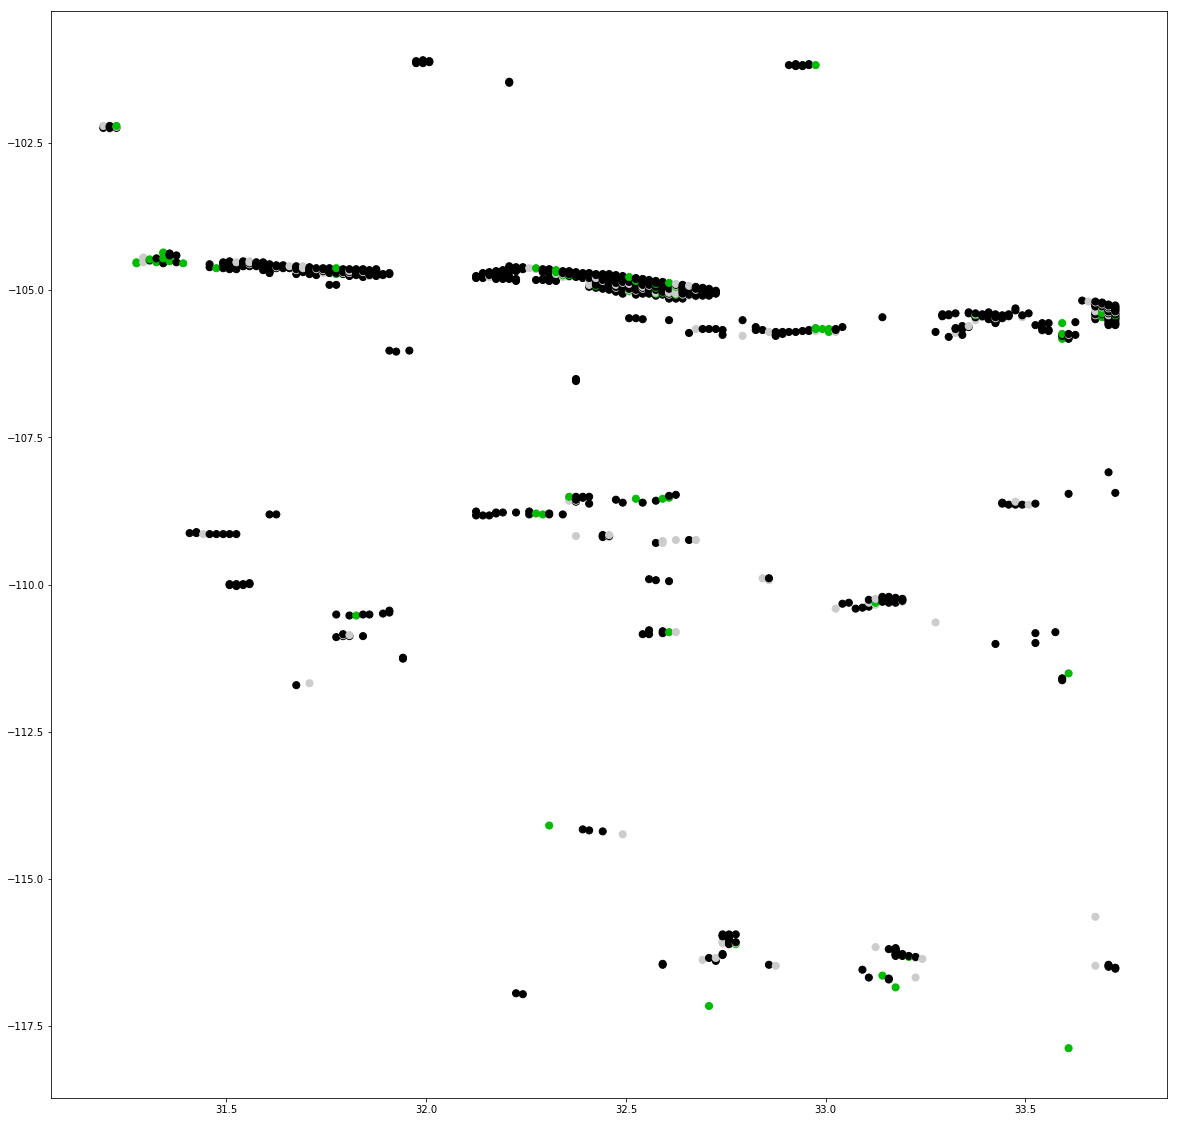

In [66]:
plotClassification(geo_position, geo_labels)

### Pass2, we classify the data based on geographic locations and capacity

In [67]:
geo_clusters = pass1(geo_matrix, n_cluster=3)

In [68]:
geo_clusters

{0: [1,
  2,
  5,
  6,
  7,
  8,
  17,
  20,
  21,
  28,
  29,
  30,
  31,
  32,
  34,
  35,
  36,
  38,
  39,
  40,
  41,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  76,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  109,
  110,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  137,
  140,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  155,
  156,
  157,
  158,
  159,
  161,
  163,
  164,
  166,
  167,
  168,
  169,
  170,
  172,
  173,
  174,
  175,
  177,
  180,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  197,
  198,
  199,
  200

In [72]:
pass2Analysis(geo_clusters, cluster_num=0)

KeyError: 5

#### We classify using num_cluster = 23

In [73]:
sample_cluster = geo_clusters[0]
position, matrix = load_matrix_on_cluster(sample_cluster)

TypeError: load_matrix_on_cluster() takes exactly 2 arguments (1 given)

In [ ]:
kmeans = KMeans(n_clusters=23, random_state=0)
labels = kmeans.fit_predict(matrix)

In [ ]:
plotKmeansClassification(position, labels, kmeans)

In [ ]:
# A full run of path 2
final_labels = pass2(geo_clusters, design_matrix)

In [ ]:
matrix = load_design_matrix()[1]

In [ ]:
final_labels

In [ ]:
calculate_cluster_rmse(final_labels, matrix)